# Chapter 3 - Statistical Experiments and Significance Testing

In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

# A/B Test

In [4]:
url1 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/web_page_data.csv')

session_times = pd.read_csv(url1)

session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [5]:
session_times.shape

(36, 2)

In [6]:
session_times['Time'] = 100 * session_times['Time']

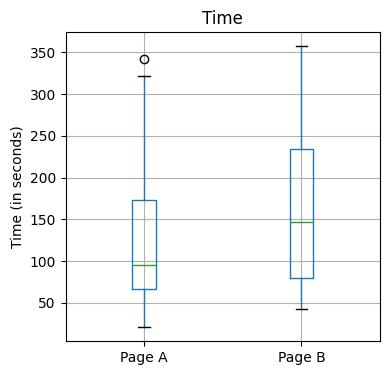

In [7]:
# Create a boxplot to visualize the distribution of session times by page
ax = session_times.boxplot(by='Page',          # Group data by 'Page' column to create individual boxplots for each page
                           column='Time',      # Boxplot will show the 'Time' column
                           figsize=(4, 4))     # Set the size of the figure

ax.set_xlabel('')                   # Remove the x-axis label for a cleaner look
ax.set_ylabel('Time (in seconds)')  # Set the y-axis label to indicate that it represents 'Time (in seconds)'
plt.suptitle('')                    # Remove the default boxplot title that comes with the groupby boxplot
plt.tight_layout()                  # Adjust the layout to remove excess white space around the plot
plt.show()                          # Display the boxplot

In [8]:
# Calculate the mean session time for 'Page A'
mean_a = session_times[session_times['Page'] == 'Page A']['Time'].mean()

# Calculate the mean session time for 'Page B'
mean_b = session_times[session_times['Page'] == 'Page B']['Time'].mean()

# Print the difference between mean session times of 'Page B' and 'Page A'
print(mean_b - mean_a)

35.66666666666667


Page B has session times that are greater than those of page A by 35.67 seconds, on average. The question is whether this difference is within the range of what random chance might produce, i.e., is statistically significant or not. 

One way to answer this is to apply a permutation test—combine all the session times together and then repeatedly shuffle and divide them into groups of 21 (recall that nA = 21 for page A) and 15 (nB = 15 for page B).

In [10]:
# Permutation test example with stickiness

def perm_fun(x, nA, nB):
    n = nA + nB                               # Total number of observations
    idx_B = set(random.sample(range(n), nB))  # Randomly select nB indices for group B
    idx_A = set(range(n)) - idx_B             # Remaining indices assigned to group A
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()  # Return the difference in means between group B and group A

# Get the number of observations in 'Page A'
nA = session_times[session_times.Page == 'Page A'].shape[0]  # Count rows where 'Page' is 'Page A'

# Get the number of observations in 'Page B'
nB = session_times[session_times.Page == 'Page B'].shape[0]  # Count rows where 'Page' is 'Page B'

# Print the result of the permutation function applied to 'Time' data
print(perm_fun(session_times['Time'], nA, nB))               # Calculate and print the difference in means for a random permutation

-9.476190476190482


Calling this function R = 1,000 times and specifying nA = 21 and nB = 15 leads to a distribution of differences in the session
times that can be plotted as a histogram. 

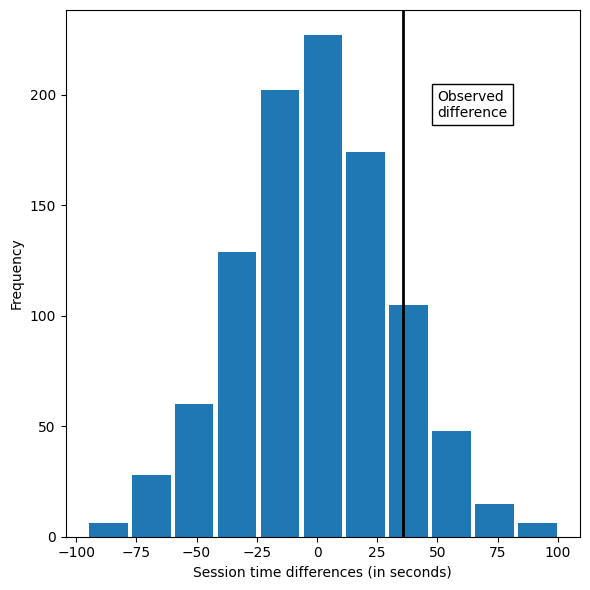

In [12]:
random.seed(1)                                                           # Set the random seed for reproducibility

perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)] # Generate 1000 permutations of the difference between means of two groups

fig, ax = plt.subplots(figsize=(6, 6))                                   # Create a figure and axis for plotting

ax.hist(perm_diffs, bins=11, rwidth=0.9)  # Plot a histogram of the permutation differences with 11 bins and 90% relative width for bars

ax.axvline(x=mean_b - mean_a, color='black', lw=2) # Draw a vertical line representing the observed difference in means between Page A and Page B

ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor': 'white'})    # Annotate the vertical line with the label "Observed difference"

ax.set_xlabel('Session time differences (in seconds)') # Set the x-axis label

ax.set_ylabel('Frequency') # Set the y-axis label

plt.tight_layout()         # Adjust the layout to avoid overlap and improve appearance

plt.show()                 # Show the plot

In [13]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)

print(np.mean(perm_diffs > mean_b - mean_a))

0.121


This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant (could plausibly have occurred by random chance).

# Statistical Significance and P-Values

The following permutation procedure asks, “If the two prices share the same conversion rate, could chance varia‐
tion produce a difference as big as 5%?”

    1. Put cards labeled 1 and 0 in a box: this represents the supposed shared conversion rate of 382 ones and 45,945 zeros (0.8246%).
    2. Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
    3. Record the number of 1s in the remaining 22,588 (same n as price B).
    4. Record the difference in proportion of 1s.
    5. Repeat steps 2–4.
    6. How often was the difference >= 0.0368?

| Outcome        | Price A | Price B  |
| -------------- | ------- | -------- |
| Conversion     | 200     | 182      |
| No conversion  | 23,539  | 22,406   |


Observed difference: 0.0368%



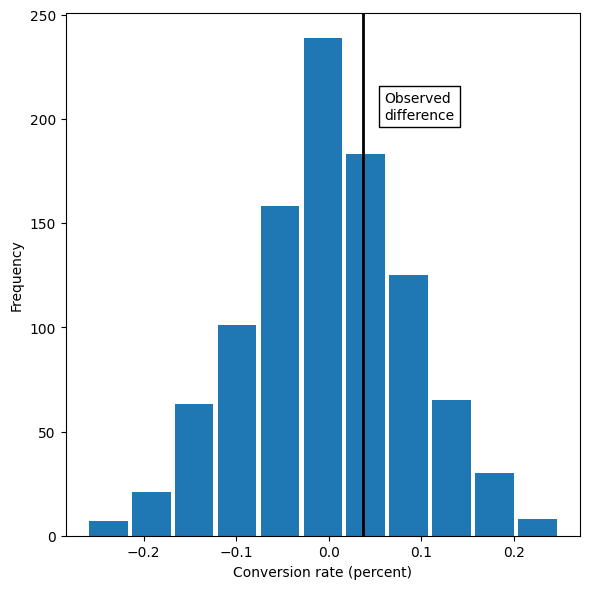

In [18]:
random.seed(1)                                      # Set the random seed for reproducibility

obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)    # Calculate the observed percentage difference in conversion rates

print(f'Observed difference: {obs_pct_diff:.4f}%\n')  # Print the observed percentage difference with 4 decimal places

conversion = [0] * 45945            # Create a list with 45945 zeros (representing non-conversions)
conversion.extend([1] * 382)        # Extend the list with 382 ones (representing conversions)
conversion = pd.Series(conversion)  # Convert the list into a Pandas Series

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]  # Run permutation test 1000 times to generate percentage differences

fig, ax = plt.subplots(figsize=(6, 6))           # Create a figure and axis for plotting
ax.hist(perm_diffs, bins=11, rwidth=0.9)         # Plot a histogram of the permutation differences
ax.axvline(x=obs_pct_diff, color='black', lw=2)  # Add a vertical line representing the observed difference
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})  # Annotate the observed difference on the plot

ax.set_xlabel('Conversion rate (percent)')  # Set the label for the x-axis
ax.set_ylabel('Frequency')                  # Set the label for the y-axis

plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.show()          # Display the plot

See the histogram of 1,000 resampled results in graph above: as it happens, in this case the observed difference of 0.0368% is well within the range of chance variation.

## p-Value

Simply looking at the graph is not a very precise way to measure statistical significance, so of more interest is the p-value. This is the frequency with which the chance model produces a result more extreme than the observed result. 

We can estimate a p-value from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference:

In [22]:
# If np.mean is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))    # How likely it is that the observed outcome happened by chance?

0.332


The Chi-square (χ²) test is used in this context to determine if there is a statistically significant difference in the conversion rates between two groups—Price A and Price B—in an A/B test setting.

The Chi-square test is used for categorical data to test whether there is a significant association between two variables. In this scenario, the two variables are:

    Group: Price A vs. Price B.
    Outcome: Conversion vs. No Conversion.

The goal of the Chi-square test is to determine whether there is an association between Price and Conversion outcome—in other words, whether the conversion rate is significantly different between Price A and Price B.

| Outcome        | Price A | Price B  |
| -------------- | ------- | -------- |
| Conversion     | 200     | 182      |
| No conversion  | 23,539  | 22,406   |


In [25]:
# Create a 2x2 contingency table with conversions and no conversions for Price A and Price B
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])  

# Perform Chi-square test on the contingency table and unpack the results
chi2, p_value, df, _ = stats.chi2_contingency(survivors)  

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


The normal approximation yields a p-value of 0.3498, which is close to the p-value obtained from the permutation test.

# t-Tests

In [28]:
res = stats.ttest_ind(session_times[session_times['Page'] == 'Page A']['Time'],  # Perform t-test on 'Time' values for 'Page A' and 'Page B'
                      session_times[session_times['Page'] == 'Page B']['Time'],  # Compare means between Page A and Page B
                      equal_var=False)                                           # Assume unequal variances for the two samples

print(f'p-value for single sided test: {res.pvalue / 2:.4f}')  # Print the one-sided p-value by dividing the two-sided p-value by 2

p-value for single sided test: 0.1408


In [29]:
# Perform an independent t-test for the means of two independent samples
tstat, pvalue, df = sm.stats.ttest_ind(  
    session_times[session_times['Page'] == 'Page A']['Time'],  # Data for Page A
    session_times[session_times['Page'] == 'Page B']['Time'],  # Data for Page B
    usevar='unequal',                                          # Specify that the variances of the two samples are unequal (Welch's t-test)
    alternative='smaller')                                     # Specify the alternative hypothesis as "Page A mean < Page B mean"

print(f'p-value: {pvalue:.4f}')  # Print the p-value of the test with four decimal places

p-value: 0.1408


* Null Hypothesis: The null hypothesis states that the mean session times for Page A and Page B are equal.
    
* Alternative Hypothesis: Since we are dividing the p-value by 2, 0.1408 indicates a one-sided test. In this case, we are testing whether the mean session time for one of the pages is significantly greater than or less than the other.

    Since p-value (0.1408) > 0.05 (alpha), it is not statistically significant, we do not have evidence to reject the null hypothesis (Page A = Page B), which means it could have easily happened due to random variation.

# ANOVA

#### Pairwise comparison
    A hypothesis test (e.g., of means) between two groups among multiple groups.
#### Omnibus test
    A single hypothesis test of the overall variance among multiple group means.
#### Decomposition of variance
    Separation of components contributing to an individual value (e.g., from the overall average, from a treatment mean, and from a residual error).
#### F-statistic
    A standardized statistic that measures the extent to which differences among group means exceed what might be expected in a chance model.
#### SS
    “Sum of squares,” referring to deviations from some average value.

### Example

Stickiness (in seconds) of four web pages:

|  | Page 1 |Page 2 |Page 3 |Page 4 |
|----------|----------|----------|----------|----------|
|   | 164  | 178   | 175   | 155   |
|   | 172   | 191   | 193   | 166   |
|   | 177   | 182   | 171   | 164   |
|   | 156   | 185   | 163   | 170   |
|   | 195   | 177   | 176   | 168   |
| Average   | 172   | 185   | 176   | 168   |
| Grand average   |  |  |  | 173.75  |

In [36]:
url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/four_sessions.csv')

four_sessions = pd.read_csv(url2)

four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [37]:
grouped = four_sessions.groupby('Page').mean()
print(grouped) 

         Time
Page         
Page 1  172.8
Page 2  182.6
Page 3  175.6
Page 4  164.6


In [38]:
df = four_sessions

# Pivot the dataframe to reshape it
reshaped_df = df.pivot_table(index=df.groupby('Page').cumcount(), columns='Page', values='Time', aggfunc='first')

# Calculate the average for each page
reshaped_df.loc['Average'] = reshaped_df.mean()

# Calculate the grand average
grand_average = reshaped_df.loc['Average'].mean()

# Append the grand average as the last row
reshaped_df.loc['Grand average'] = [np.nan, np.nan, np.nan, grand_average]

# Display the reshaped dataframe
reshaped_df

Page,Page 1,Page 2,Page 3,Page 4
0,164.0,178.0,175.0,155.0
1,172.0,191.0,193.0,166.0
2,177.0,182.0,171.0,164.0
3,156.0,185.0,163.0,170.0
4,195.0,177.0,176.0,168.0
Average,172.8,182.6,175.6,164.6
Grand average,NaN,NaN,NaN,173.9


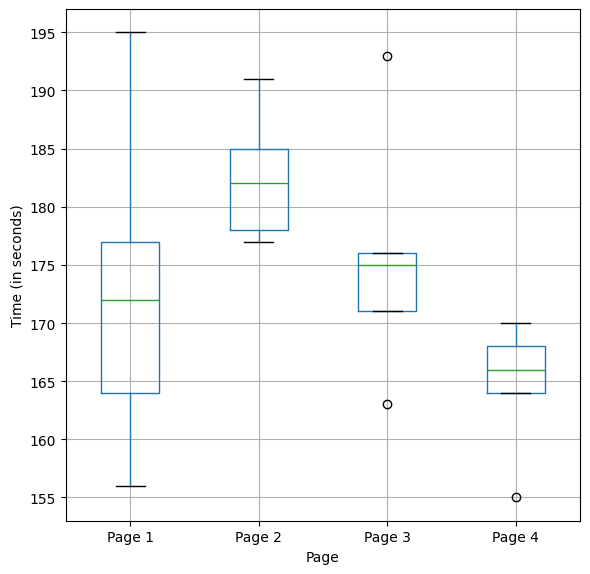

In [39]:
ax = four_sessions.boxplot(by='Page', column='Time', figsize=(6, 6))  # Create a boxplot of the 'Time' column, grouped by the 'Page' column
ax.set_xlabel('Page')                                                 # Set the x-axis label as 'Page'
ax.set_ylabel('Time (in seconds)')                                    # Set the y-axis label as 'Time (in seconds)'

plt.suptitle('')  # Remove the default suptitle generated by the 'by' parameter in the boxplot
plt.title('')     # Remove the default title for the plot

plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()          # Display the boxplot

The procedure used to test this is ANOVA. The basis for it can be seen in the follow‐
ing resampling procedure (specified here for the A/B/C/D test of web page
stickiness):

1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

What proportion of the time did the resampled variance exceed the observed variance? This is the p-value.

In [41]:
# Calculate the observed variance of the means for 'Time' across different pages
observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]  

print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())  # Print the observed mean 'Time' for each 'Page'
print('Variance:', observed_variance)                                          # Print the variance of these observed means

# Permutation test example for observed variance
def perm_test(df):                                         # Define a function to perform a permutation test
    df = df.copy()                                         # Make a copy of the DataFrame to avoid modifying the original
    df['Time'] = np.random.permutation(df['Time'].values)  # Randomly shuffle the 'Time' values
    return df.groupby('Page').mean().var().iloc[0]         # Return the variance of the means of 'Time' across pages after permutation
    
print('Permutation Test:', perm_test(four_sessions))  # Run the permutation test function and print the result

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Permutation Test: 3.2666666666666537


#### Permutation Test Function:
* The function `perm_test()` shuffles the `Time` values across all pages to break the original association between page and time.
* After shuffling, it calculates the variance of the mean times for each page again, providing a measure that can be compared with the original observed variance.
* This approach helps evaluate whether the observed variance is statistically significant or could occur by chance.

Pr(Prob) 0.07866666666666666


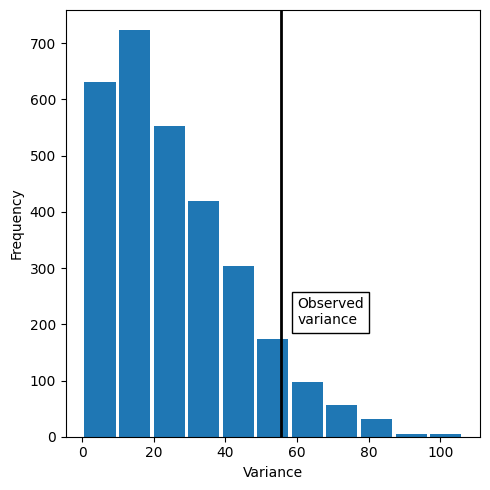

In [43]:
random.seed(1)  

# Perform permutation test 3000 times and collect variance results
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

# Calculate the probability that the permutation variances are greater than the observed variance
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

# Plot histogram of permutation variances
fig, ax = plt.subplots(figsize=(5, 5))                               # Create a figure and axis for plotting
ax.hist(perm_variance, bins=11, rwidth=0.9)                          # Plot histogram with 11 bins and bar width of 90%
ax.axvline(x=observed_variance, color='black', lw=2)                 # Draw a vertical line representing the observed variance
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor': 'white'})  # Annotate the line with 'Observed variance'
ax.set_xlabel('Variance')                                            # Set label for x-axis
ax.set_ylabel('Frequency')                                           # Set label for y-axis

plt.tight_layout()  # Adjust layout to remove excess whitespace
plt.show()          # Display the plot

#### Summary of the Code:
Permutation Test:

* perm_variance stores the results of 3000 random shuffles of the Time values and computes the variance of group means for each shuffle.
* Pr(Prob) calculates how often the variance from the shuffles exceeds the observed variance, providing an estimate of the p-value.

Plotting:

* The histogram represents the distribution of variances from the permutation test.
* The vertical line and annotation highlight the observed variance to visually compare it with the distribution of random variances. This helps to assess if the observed value is typical or rare under the null hypothesis (random distribution).

#### Conclusion

The p-value, given by Pr(Prob), is 0.0827. In other words, given the same underlying stickiness, 8.3% of the time the response rate among four pages might differ as much as was actually observed, just by chance. This degree of improbability falls short of the traditional statistical threshold of 5%, so we conclude that the difference among the four pages could have arisen by chance.

# F-Statistic

Just like the t-test can be used instead of a permutation test for comparing the mean
of two groups, there is a statistical test for ANOVA based on the F-statistic. The Fstatistic is based on the ratio of the variance across group means (i.e., the treatment
effect) to the variance due to residual error. The higher this ratio, the more statisti‐
cally significant the result. If the data follows a normal distribution, then statistical
theory dictates that the statistic should have a certain distribution. Based on this, it is
possible to compute a p-value.

In [48]:
# Fit an Ordinary Least Squares (OLS) model with 'Time' as the dependent variable and 'Page' as the independent variable
model = smf.ols('Time ~ Page', data=four_sessions).fit()  

aov_table = sm.stats.anova_lm(model)  # Perform ANOVA on the fitted model to analyze the variance
aov_table                             # Print the ANOVA table with summary statistics

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


#### Degrees of Freedom (df):

* Page (df=3.0): This is the number of groups (pages) minus one (4 pages - 1 = 3). This value represents the degrees of freedom for the between-group variability.
* Residual (df=16.0): This represents the degrees of freedom for the within-group (residual) variability, which is the total number of data points minus the number of groups.

#### Sum of Squares (sum_sq):

* Page (sum_sq=831.4): This is the sum of squared deviations between the group means (Page) and the overall mean. It represents the variability explained by the differences between the page groups.
* Residual (sum_sq=1618.4): This is the sum of squared deviations of each observation from its group mean, representing the unexplained variability (the variability within the groups).
  
#### Mean Square (mean_sq):

* Page (mean_sq=277.13): This is the average variability between the groups, calculated as sum_sq / df.
* Residual (mean_sq=101.15): This is the average variability within the groups, also calculated as sum_sq / df.

#### F-statistic (F=2.739825):

This is the ratio of the mean square between the groups (Page) to the mean square within the groups (Residual). It tests whether there is a significant difference between the means of the groups. The larger the F-statistic, the more likely it is that there is a significant difference between groups.

#### P-value (PR(>F)=0.077586):

The p-value indicates the probability of observing the F-statistic or a more extreme value if there is no real difference between the groups (i.e., if the null hypothesis is true).
In this case, the p-value is 0.0776, which is slightly above the common significance threshold of 0.05. Therefore, we fail to reject the null hypothesis at the 5% significance level, which suggests that there is no statistically significant difference in the Time spent on the pages.

#### Conclusion:
    The p-value (0.0776) suggests that there is no strong evidence that the mean Time differs significantly between the different pages, at the 5% significance level.

    However, the p-value is close to the threshold, which indicates a potential difference, and it might be worth exploring further with more data or a different approach.

In [50]:
# Perform a one-way ANOVA to compare the means of 'Time' for the four pages
res = stats.f_oneway(
    four_sessions[four_sessions['Page'] == 'Page 1']['Time'],  # Data for 'Page 1'
    four_sessions[four_sessions['Page'] == 'Page 2']['Time'],  # Data for 'Page 2'
    four_sessions[four_sessions['Page'] == 'Page 3']['Time'],  # Data for 'Page 3'
    four_sessions[four_sessions['Page'] == 'Page 4']['Time']   # Data for 'Page 4'
)

# Print the F-Statistic divided by 2
print(f'F-Statistic: {res.statistic:.4f}')

# Print the p-value divided by 2 for a one-sided test
print(f'p-value: {res.pvalue:.4f}')

F-Statistic: 2.7398
p-value: 0.0776


### Two-Way ANOVA
The A/B/C/D test just described is a “one-way” ANOVA, in which we have one factor
(group) that is varying. We could have a second factor involved—say, “weekend ver‐
sus weekday”—with data collected on each combination (group A weekend, group A
weekday, group B weekend, etc.). This would be a “two-way ANOVA,” and we would
handle it in similar fashion to the one-way ANOVA by identifying the “interaction
effect.” After identifying the grand average effect and the treatment effect, we then
separate the weekend and weekday observations for each group and find the differ‐
ence between the averages for those subsets and the treatment average.

In [52]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Assuming 'data' is a DataFrame containing columns 'len', 'supp', 'dose'
data = pd.DataFrame({
    'len': [10, 15, 20, 25, 30],
    'supp': ['A', 'A', 'B', 'B', 'A'],
    'dose': [1, 2, 1, 2, 2]
})

# Define the model and fit it
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()

# Perform ANOVA
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(supp),38.095238,1.0,0.338624,0.664492
C(dose),100.595238,1.0,0.894180,0.517792
C(supp):C(dose),16.071429,1.0,0.142857,0.769947
Residual,112.500000,1.0,NaN,NaN


Based on the ANOVA table, none of the factors (supp, dose) nor their interaction (supp:dose) have a statistically significant effect on the response variable (len). Here are the key points to summarize the findings:

**High p-values** (all greater than 0.05 for supp, dose, and their interaction) indicate that there is no strong evidence to reject the null hypothesis. Therefore, we cannot conclude that these factors have a meaningful impact on the response variable (len).

**The F-statistics** are all relatively low (< 1), meaning that the explained variance due to supp, dose, or their interaction is not substantially larger than the unexplained variance (i.e., the residuals).

**The Residual Sum of Squares** (112.5) is considerably high compared to the sum of squares for the factors, suggesting that most of the variation in the response variable remains unexplained by the factors included in the model.

# Chi-Square Test

### Chi-Square Test: A Resampling Approach

Suppose you are testing three different headlines—A, B, and C—and you run them
each on 1,000 visitors, with the results shown bellow:

|           | Headline A | Headline B | Headline C |
|-----------|------------|------------|------------|
| Click     | 14         | 8          | 12         |
| No-click  | 986        | 992        | 988        |


Expected if all three headlines have the same click rate (null hypothesis):

|           | Headline A | Headline B | Headline C |
|-----------|------------|------------|------------|
| Click     | 11.33      | 11.33      | 11.33      |
| No-click  | 988.67     | 988.67     | 988.67     |

The Pearson residual is defined as:

$$
R = \frac{ \text{Observed} - \text{Expected} }{ \sqrt{\text{Expected}} }
$$


|            | Headline A | Headline B | Headline C |
|------------|------------|------------|------------|
| Click      | 0.792      | -0.990     | 0.198      |
| No-click   | -0.085     | 0.106      | -0.021     |


$$
\chi = \sum_i \sum_j R^2
$$


Where r and c are the number of rows and columns, respectively. The chi-square statistic for this example is 1.666. Is that more than could reasonably occur in a chance model?

In [63]:
# Define the data
data = {
    "Headline": ["Headline A", "Headline A", "Headline B", "Headline B", "Headline C", "Headline C"],
    "Click": ["Click", "No-click", "Click", "No-click", "Click", "No-click"],
    "Rate": [14, 986, 8, 992, 12, 988]
}

# Create the DataFrame
click_rate = pd.DataFrame(data)

# Display the DataFrame
click_rate

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986
2,Headline B,Click,8
3,Headline B,No-click,992
4,Headline C,Click,12
5,Headline C,No-click,988


In [64]:
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [65]:
# Calculate the row-wise average for each row in the 'clicks' DataFrame
row_average = clicks.mean(axis=1)  # 'axis=1' indicates calculating the mean across columns for each row

# Create a new DataFrame with each column ('Headline A', 'Headline B', 'Headline C') filled with the row-wise average
pd.DataFrame({
    'Headline A': row_average,  # Assign 'row_average' as the value for each row in 'Headline A'
    'Headline B': row_average,  # Assign 'row_average' as the value for each row in 'Headline B'
    'Headline C': row_average,  # Assign 'row_average' as the value for each row in 'Headline C'
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


We can test with this resampling algorithm:

1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed?
   
That’s the p-value.

In [67]:
# Resampling approach to evaluate statistical significance

# Create a list 'box' representing outcomes: 34 clicks (1) and 2966 no-clicks (0)
box = [1] * 34          # Add 34 values of 1 representing clicks
box.extend([0] * 2966)  # Extend list with 2966 values of 0 representing no-clicks
random.shuffle(box)     # Shuffle the list randomly

# Function to calculate the Chi-square statistic
def chi2(observed, expected):
    pearson_residuals = []                              # List to store Pearson residuals for each cell
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])  # Calculate residual for each observed value
    
    return np.sum(pearson_residuals)                    # Return sum of Pearson residuals to get Chi-square value

# Expected values for clicks and no-clicks based on uniform distribution assumption
expected_clicks = 34 / 3                         # Expected clicks are evenly split among three groups
expected_noclicks = 1000 - expected_clicks       # Expected no-clicks for each group
expected = [expected_clicks, expected_noclicks]  # Combine expected clicks and no-clicks

# Calculate Chi-square statistic for the observed clicks in the 'clicks' DataFrame
chi2observed = chi2(clicks.values, expected)

# Define a function for generating a permutation of the 'box' and calculating Chi-square
def perm_fun(box):
    
    random.shuffle(box)  # Shuffle the box randomly
    
    # Calculate sample clicks for each group (3 groups, each with 1000 items)
    sample_clicks = [sum(box[0:1000]), sum(box[1000:2000]), sum(box[2000:3000])]
    
    # Calculate sample no-clicks for each group
    sample_noclicks = [1000 - n for n in sample_clicks]
    
    # Return Chi-square value for this permutation
    return chi2([sample_clicks, sample_noclicks], expected)

# Run permutation test 2000 times to create distribution of Chi-square statistics
perm_chi2 = [perm_fun(box) for _ in range(2000)]

# Calculate resampled p-value based on proportion of permutations that have a greater chi2 value
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)

# Print the observed Chi-square statistic and the resampled p-value
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4660


The Chi-Square statistic (χ²) measures the discrepancy between the observed frequencies and the expected frequencies.

A p-value of 0.4660 means that 46.6% of the time, the Chi-Square statistic calculated from randomly shuffled data was greater than or equal to the observed Chi-Square (1.6659). This is a high p-value, meaning that the observed deviation is not unusual compared to the distribution expected by chance. We fail to reject the null hypothesis.

The differences in click rates among the headlines could be due to random chance

In [69]:
# Perform a Chi-Square test of independence on the contingency table 'clicks'
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)

print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


The above algorithm uses sampling into the three sets without replacement. Alternatively, it is also possible to sample with replacement.

In [71]:
expected = [expected_clicks, expected_noclicks]

# Define a function to create a resampled version of the original data with replacement
def sample_with_replacement(box):
    # Randomly sample 1000 observations with replacement from the box, repeated three times
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    
    # Calculate the number of no-clicks based on the sampled number of clicks
    sample_noclicks = [1000 - n for n in sample_clicks]
    
    # Calculate the Chi-Square statistic for the resampled data
    return chi2([sample_clicks, sample_noclicks], expected)

# Perform resampling 2000 times and calculate the Chi-Square statistic for each sample
perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

# Calculate the proportion of resampled Chi-Square statistics that are greater than the observed one
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)

# Print the observed Chi-Square statistic and the resampled p-value
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4845


### Figure chi-sq distribution

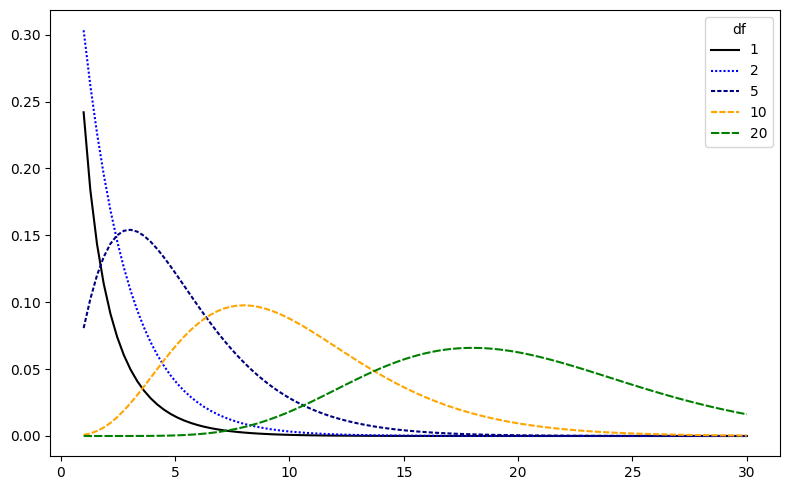

In [73]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]  # Generate 100 equally spaced values between 1 and 30

# Create a DataFrame containing x values and chi-squared probability density functions with different degrees of freedom (df)
chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),   # Chi-square PDF for df=1
    'chi_2': stats.chi2.pdf(x, df=2),   # Chi-square PDF for df=2
    'chi_5': stats.chi2.pdf(x, df=5),   # Chi-square PDF for df=5
    'chi_10': stats.chi2.pdf(x, df=10), # Chi-square PDF for df=10
    'chi_20': stats.chi2.pdf(x, df=20)  # Chi-square PDF for df=20
})

fig, ax = plt.subplots(figsize=(8, 5))  # Create a figure and axis for plotting, with a specific size of 4x2.5 inches

# Plot the Chi-square PDFs for different degrees of freedom with different line styles
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')                  # Plot df=1 with a solid line
ax.plot(chi.x, chi.chi_2, color='blue', linestyle=(0, (1, 1)), label='2')           # Plot df=2 with dashed line
ax.plot(chi.x, chi.chi_5, color='navy', linestyle=(0, (2, 1)), label='5')           # Plot df=5 with dashed line with larger gaps
ax.plot(chi.x, chi.chi_10, color='orange', linestyle=(0, (3, 1)), label='10')       # Plot df=10 with longer dashes
ax.plot(chi.x, chi.chi_20, color='green', linestyle=(0, (4, 1)), label='20')        # Plot df=20 with even longer dashes

ax.legend(title='df')  # Add a legend to the plot, with the title 'df' to indicate the degrees of freedom for each line

plt.tight_layout()  # Adjust the layout to minimize overlap and improve appearance
plt.show()  # Display the plot

*Chi-square distribution with various degrees of freedom*

# Scientific Fraud

In [76]:
# Create the data as a list of dictionaries
data = [
    {"Digit": 0, "Frequency": 14},
    {"Digit": 1, "Frequency": 71},
    {"Digit": 2, "Frequency": 7},
    {"Digit": 3, "Frequency": 65},
    {"Digit": 4, "Frequency": 23},
    {"Digit": 5, "Frequency": 19},
    {"Digit": 6, "Frequency": 12},
    {"Digit": 7, "Frequency": 45},
    {"Digit": 8, "Frequency": 53},
    {"Digit": 9, "Frequency": 6}
]

# Create the DataFrame
imanishi = pd.DataFrame(data)

imanishi

,Digit,Frequency
0,0,14
1,1,71
2,2,7
3,3,65
4,4,23
5,5,19
6,6,12
7,7,45
8,8,53
9,9,6


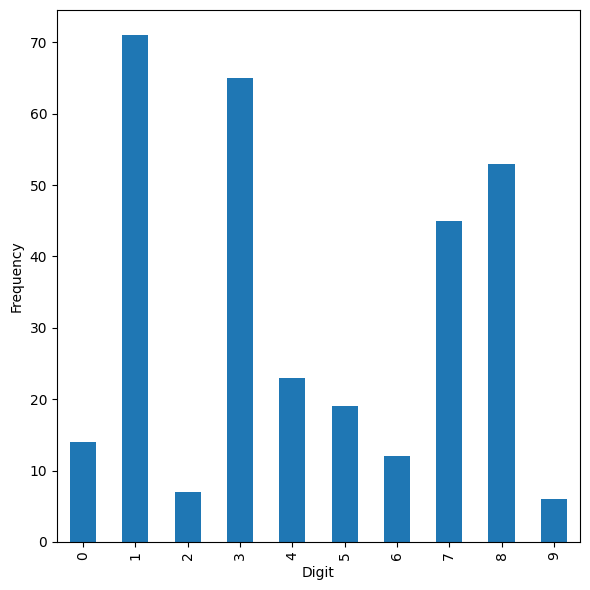

In [77]:
imanishi.columns = [c.strip() for c in imanishi.columns]      # Remove leading/trailing whitespace from each column name

ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False, figsize=(6, 6))  # Create a bar plot 
                                                  
ax.set_xlabel('Digit')      # Set the x-axis label to 'Digit'
ax.set_ylabel('Frequency')  # Set the y-axis label to 'Frequency'

plt.tight_layout()  # Adjust the layout to minimize overlaps
plt.show()          # Display the plot

# Power and Sample Size

If you run a web test, how do you decide how long it should run (i.e., how many impressions per treatment are needed)?
One step in statistical calculations for sample size is to ask “Will a hypothesis test actually reveal a difference between treatments A and B?” 

The most common use of power calculations is to estimate how big a sample you will need.

#### For example, suppose current click-through rates are about 1.1%, and you are seeking a 10% boost to 1.21%.

In [81]:
# Calculate the effect size for proportions between 0.0121 and 0.011 using Cohen's h formula
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)  

analysis = sm.stats.TTestIndPower()  # Create an instance of TTestIndPower to perform power analysis for an independent t-test

result = analysis.solve_power(effect_size=effect_size,  # Determine the sample size required to achieve a given power level
                              alpha=0.05,               # Set the significance level (alpha) to 0.05
                              power=0.8,                # Set the desired power to 0.8 (80%)
                              alternative='larger')     # Use a one-sided test, as we are interested in a specific direction 
                                                        # (alternative hypothesis is 'larger')

print('Sample Size: %.3f' % result)  # Print the calculated required sample size

Sample Size: 116602.393


#### Suppose you are conducting an A/B test for two different versions of an online advertisement:

    Version A has a conversion rate of 1.65% (or 0.0165).
    Version B has a conversion rate of 1.1% (or 0.011).
  
**You want to determine how many visitors you need for each version of the advertisement to detect a statistically significant difference between the conversion rates, with a 95% confidence level (alpha=0.05) and 80% power.**

Typically, researchers aim for a power of 0.8 (or 80%), which means there is an 80% chance of correctly detecting an effect if it exists. This reduces the risk of a Type II error (false negative).

In [83]:
# Calculate the effect size for proportions between 0.0165 and 0.011 using Cohen's h formula
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)  

analysis = sm.stats.TTestIndPower()  # Create an instance of TTestIndPower to perform power analysis for an independent t-test

result = analysis.solve_power(effect_size=effect_size,  # Determine the sample size required to achieve a given power level
                              alpha=0.05,               # Set the significance level (alpha) to 0.05
                              power=0.8,                # Set the desired power to 0.8 (80%)
                              alternative='larger')     # Use a one-sided test, as we are interested in a specific direction 
                                                        # (alternative hypothesis is 'larger')

print('Sample Size: %.3f' % result)  # Print the calculated required sample size

Sample Size: 5488.408
